## Loading data

 - **train** images + segmentation masks
 - **validation** images + segmentation masks
 - **test** images + segmentation masks
 
All images have 480 pixels height and 640 pixels width.

In [1]:
import os

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
x_train_dir = "data\images\\train"
y_train_dir = "data\masks\\train"

x_test_dir = "data\images\\test"
y_test_dir = "data\masks\\test"

In [3]:
# helper function for data visualization
def visualize(**images):
    """Plot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(" ".join(name.split("_")).title())
        plt.imshow(image)
    plt.show()

### Dataloader

Writing helper class for data extraction, tranformation and preprocessing  
https://pytorch.org/docs/stable/data

In [4]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [5]:
class Dataset(BaseDataset):
    """Udder Dataset. Read images, apply augmentation and preprocessing transformations.

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. normalization, shape manipulation, etc.)

    """

    CLASSES = ["unlabelled", "udder"]
    CLASS_VALUES = [0, 255]

    def __init__(
        self,
        images_dir,
        masks_dir,
        classes=None,
        augmentation=None,
        preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [
            os.path.join(masks_dir, os.path.splitext(image_id)[0] + ".png")
            for image_id in self.ids
        ]

        # convert str names to class values on masks
        self.class_values = [
            self.CLASS_VALUES[self.CLASSES.index(cls.lower())] for cls in classes
        ]

        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)

        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype("float")

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample["image"], sample["mask"]

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample["image"], sample["mask"]

        return image, mask

    def __len__(self):
        return len(self.ids)

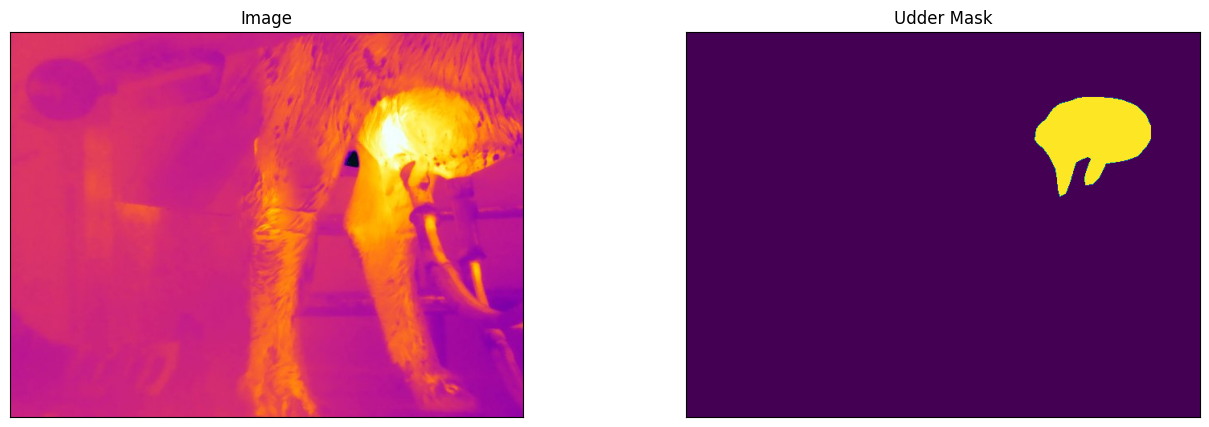

In [6]:
# Lets look at data we have

dataset = Dataset(x_train_dir, y_train_dir, classes=["udder"])

image, mask = dataset[0]  # get some sample
visualize(
    image=image,
    udder_mask=mask.squeeze(),
)

### Augmentations

Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.  

Since our dataset is very small we will apply a large number of different augmentations:
 - horizontal flip
 - affine transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 - gaussian noise

All this transforms can be easily applied with [**Albumentations**](https://github.com/albu/albumentations/) - fast augmentation library.

In [7]:
import albumentations as albu

In [8]:
def get_training_augmentation():
    train_transform = [
        albu.HorizontalFlip(),
        albu.ShiftScaleRotate(
            shift_limit=0.1, scale_limit=0.5, border_mode=1, rotate_limit=30
        ),
        albu.PadIfNeeded(
            min_height=480, min_width=640, border_mode=1, always_apply=True
        ),
        albu.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2),
        #albu.GaussNoise(var_limit=10),
        albu.OneOf([albu.Sharpen(), albu.Blur(blur_limit=3)]),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(
            min_height=480, min_width=640, border_mode=1, always_apply=True
        )
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype("float32")


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform

    Args:
        preprocessing_fn (callbale): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose

    """

    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

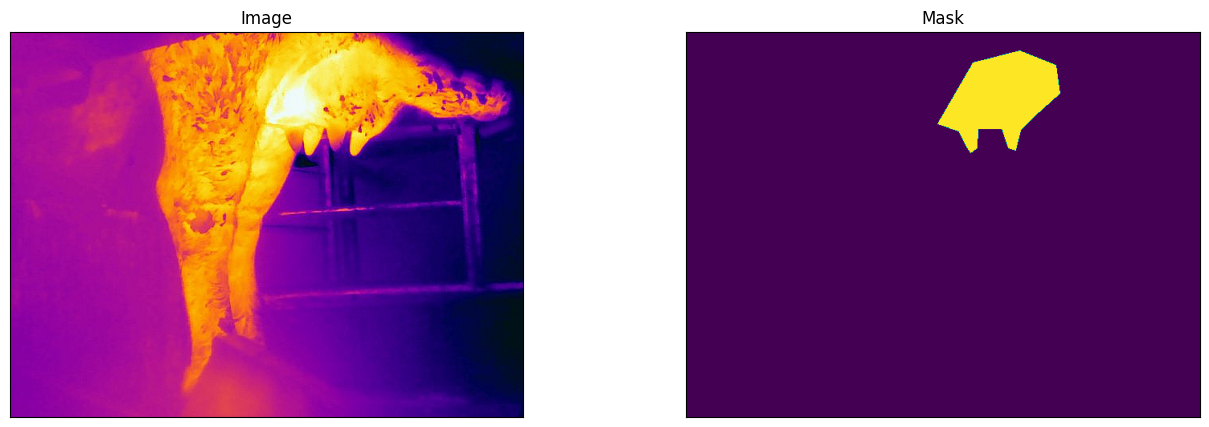

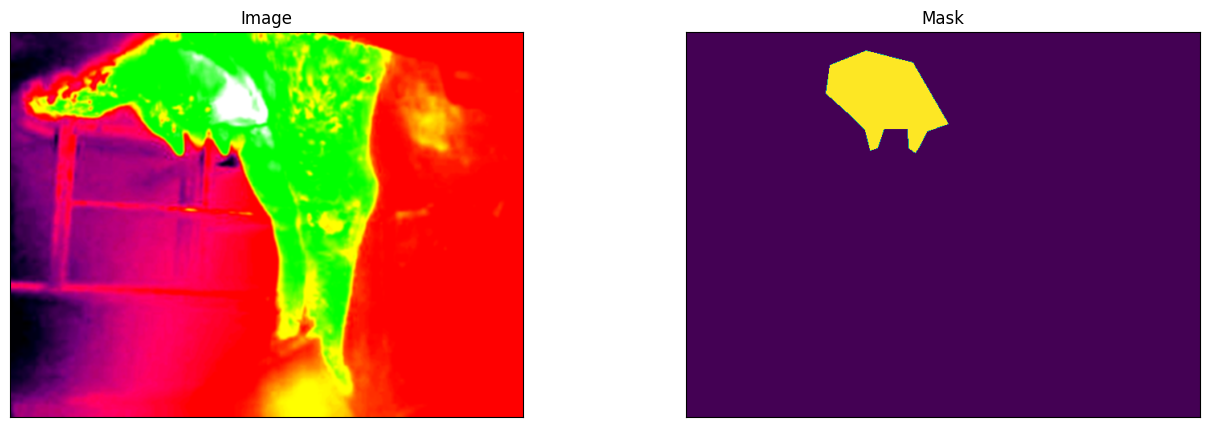

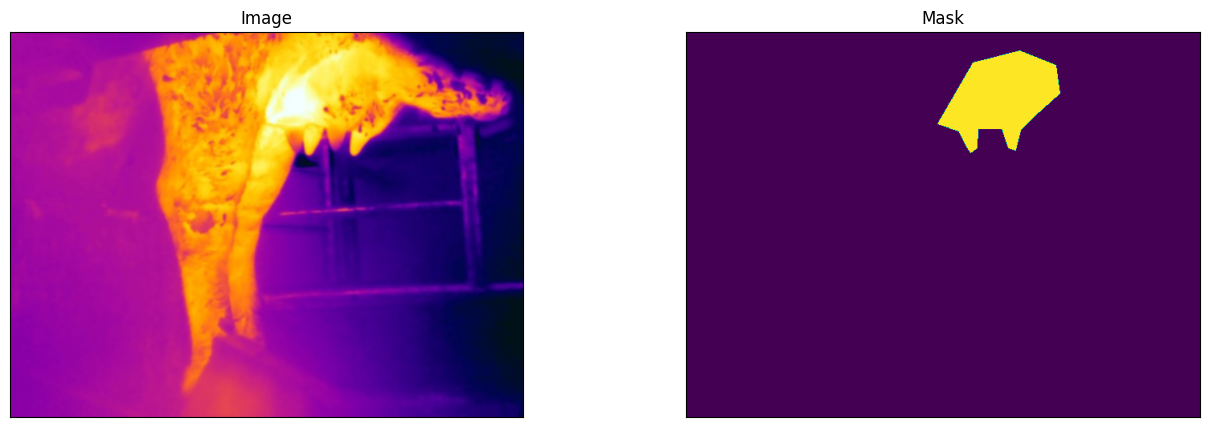

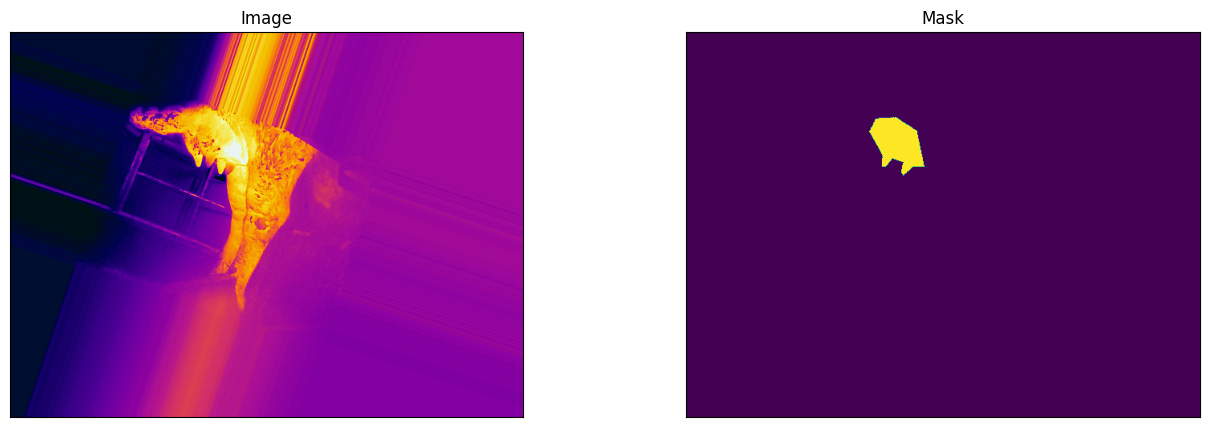

In [9]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    x_train_dir,
    y_train_dir,
    augmentation=get_training_augmentation(),
    classes=["udder"],
)

# same image with different random transforms
for i in range(4):
    image, mask = augmented_dataset[7]
    visualize(image=image, mask=mask.squeeze(-1))

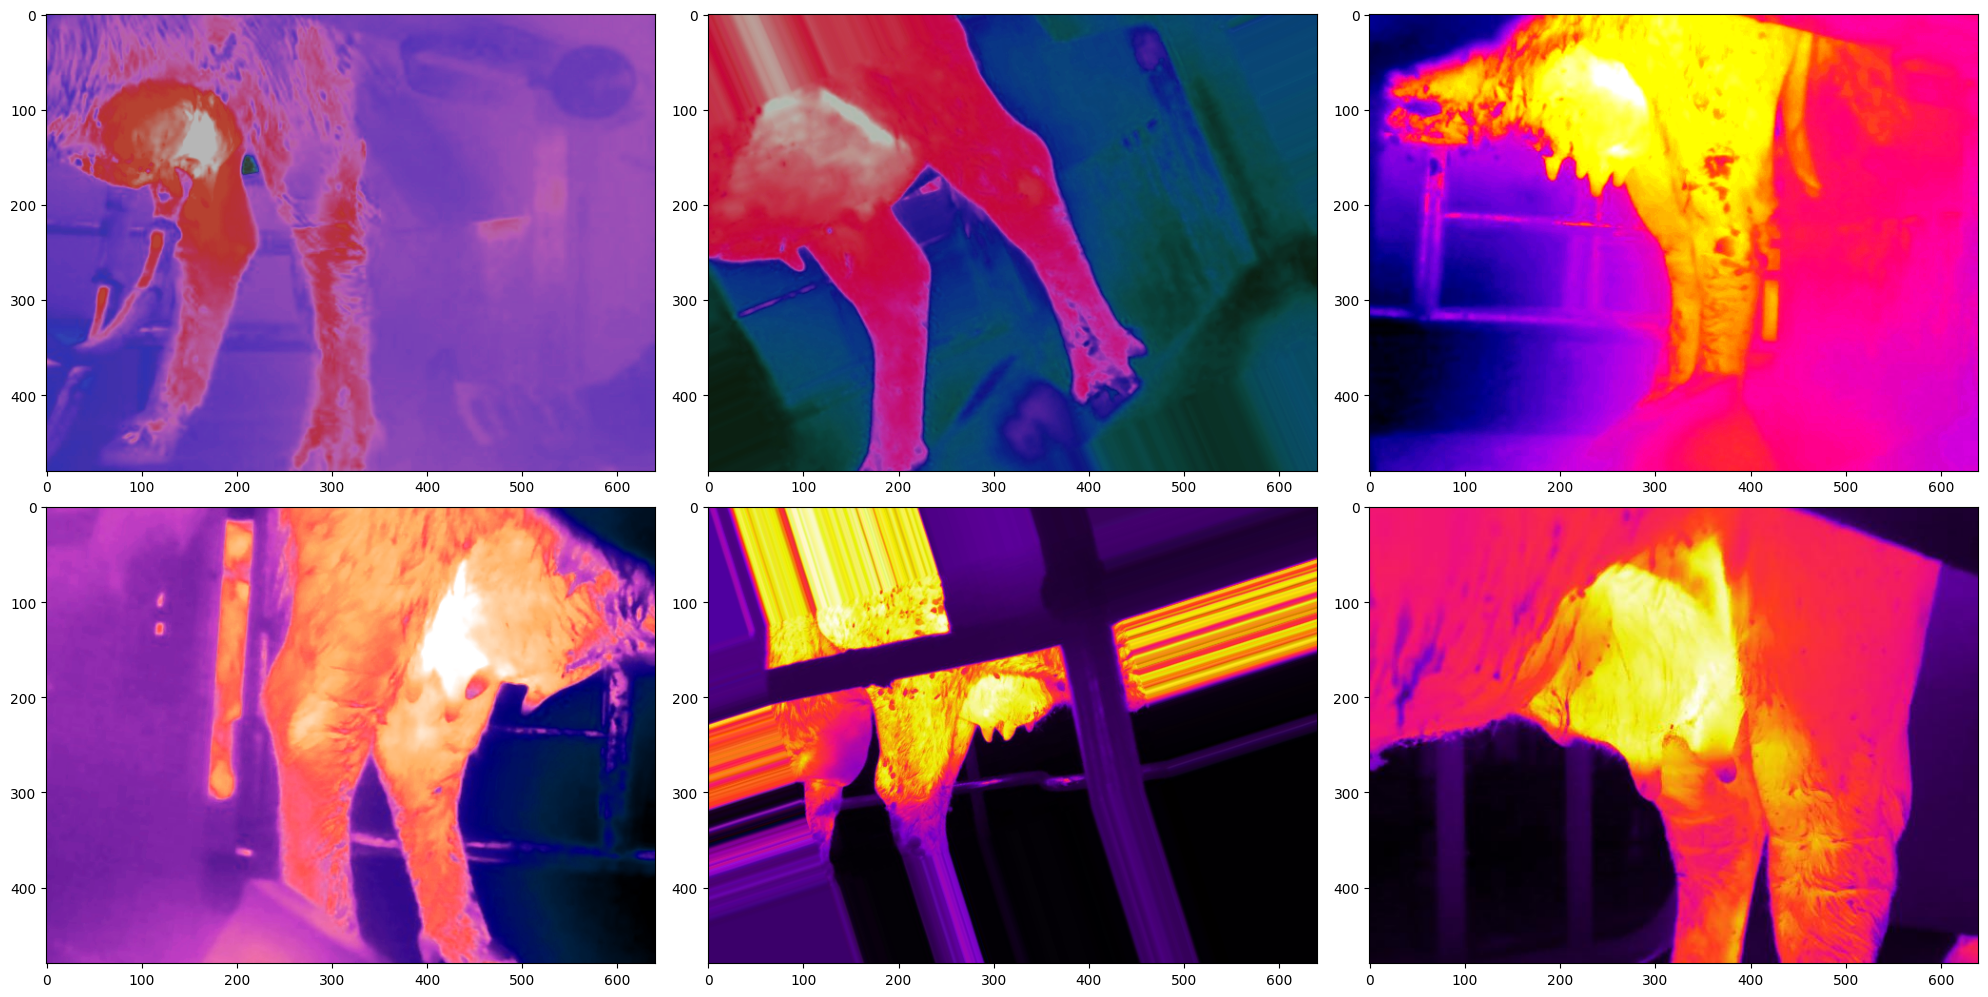

In [10]:
import matplotlib.pyplot as plt
import numpy as np


def img_is_color(img):
    if len(img.shape) == 3:
        # Check the color channels to see if they're all the same.
        c1, c2, c3 = img[:, :, 0], img[:, :, 1], img[:, :, 2]
        if (c1 == c2).all() and (c2 == c3).all():
            return True

    return False


def show_image_list(
    list_images,
    list_titles=None,
    list_cmaps=None,
    grid=True,
    num_cols=2,
    figsize=(20, 10),
):
    """
    Shows a grid of images, where each image is a Numpy array. The images can be either
    RGB or grayscale.

    Parameters:
    ----------
    images: list
        List of the images to be displayed.
    list_titles: list or None
        Optional list of titles to be shown for each image.
    list_cmaps: list or None
        Optional list of cmap values for each image. If None, then cmap will be
        automatically inferred.
    grid: boolean
        If True, show a grid over each image
    num_cols: int
        Number of columns to show.
    figsize: tuple of width, height
        Value to be passed to pyplot.figure()
    title_fontsize: int
        Value to be passed to set_title().
    """

    assert isinstance(list_images, list)
    assert len(list_images) > 0
    assert isinstance(list_images[0], np.ndarray)

    if list_titles is not None:
        assert isinstance(list_titles, list)
        assert len(list_images) == len(list_titles), "%d imgs != %d titles" % (
            len(list_images),
            len(list_titles),
        )

    if list_cmaps is not None:
        assert isinstance(list_cmaps, list)
        assert len(list_images) == len(list_cmaps), "%d imgs != %d cmaps" % (
            len(list_images),
            len(list_cmaps),
        )

    num_images = len(list_images)
    num_cols = min(num_images, num_cols)
    num_rows = int(num_images / num_cols) + (1 if num_images % num_cols != 0 else 0)

    # Create a grid of subplots.
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)

    # Create list of axes for easy iteration.
    if isinstance(axes, np.ndarray):
        list_axes = list(axes.flat)
    else:
        list_axes = [axes]

    for i in range(num_images):
        img = list_images[i]
        cmap = (
            list_cmaps[i]
            if list_cmaps is not None
            else (None if img_is_color(img) else "gray")
        )

        list_axes[i].imshow(img, cmap=cmap)
        list_axes[i].grid(grid)

    for i in range(num_images, len(list_axes)):
        list_axes[i].set_visible(False)

    fig.tight_layout()
    _ = plt.show()


images = []
for idx in range(6):
    image, _ = augmented_dataset[idx]
    images.append(image)

show_image_list(images, grid=False, num_cols=3)

## Create model and train 

In [ ]:
import torch
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils as smp_utils

In [12]:
ENCODER = "mit_b2"
ENCODER_WEIGHTS = "imagenet"
CLASSES = ["udder"]
ACTIVATION = (
    "sigmoid"  # could be None for logits or 'softmax2d' for multiclass segmentation
)
DEVICE = "cuda"

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
    decoder_attention_type="scse"
)

# uncomment for encoder weights freezing
for param in model.encoder.parameters():
    param.requires_grad = False

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [13]:
train_dataset = Dataset(
    x_train_dir,
    y_train_dir,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataset = Dataset(
    x_test_dir,
    y_test_dir,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [14]:
from torch.nn.modules.loss import _Loss


class WeightedLoss(_Loss):
    """Wrapper class around loss function that applies weighted with fixed factor.
    This class helps to balance multiple losses if they have different scales
    """

    def __init__(self, loss, weight=1.0):
        super().__init__()
        self.loss = loss
        self.weight = weight

    def forward(self, *input):
        return self.loss(*input) * self.weight


class JointLoss(_Loss):
    """
    Wrap two loss functions into one. This class computes a weighted sum of two losses.
    """

    def __init__(
        self,
        first: torch.nn.Module,
        second: torch.nn.Module,
        first_weight=1.0,
        second_weight=1.0,
    ):
        super().__init__()
        self.__name__ = "joint_loss"
        self.first = WeightedLoss(first, first_weight)
        self.second = WeightedLoss(second, second_weight)

    def forward(self, *input):
        return self.first(*input) + self.second(*input)

In [15]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

dice_loss = smp_utils.losses.DiceLoss()
focal_loss = smp.losses.FocalLoss(mode="binary")
loss = JointLoss(dice_loss, focal_loss, first_weight = 1, second_weight = 2)

metrics = [
    smp_utils.metrics.IoU(threshold=0.5), # threshold for binarization post activation
    smp_utils.metrics.Precision(), # precision over the pixels correctly identified as udder
    smp_utils.metrics.Recall(), # recall over the pixels correctly identified as udder
    smp_utils.metrics.Fscore(), # f1-score over the pixels correctly identified as udder
]

optimizer = torch.optim.RAdam(
    [
        dict(params=model.parameters(), lr=0.001, weight_decay=0.00002),
    ]
)

In [16]:
# create epoch runners
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp_utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

test_epoch = smp_utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

In [17]:
NUM_EPOCHS = 10

train_logs = list()
test_logs = list()

max_score = 0
for i in range(0, NUM_EPOCHS):
    print("\nEpoch: {}".format(i))
    current_train_logs = train_epoch.run(train_loader)
    train_logs.append(current_train_logs)
    current_test_logs = test_epoch.run(test_loader)
    test_logs.append(current_test_logs)

    # do something (save model, change lr, etc.)
    if max_score < current_test_logs["iou_score"]:
        max_score = current_test_logs["iou_score"]
        torch.save(model, "./best_model.pth")
        print("Model saved!")


Epoch: 0
valid: 100%|██████████| 431/431 [00:18<00:00, 23.85it/s, joint_loss - 0.7113, iou_score - 0.5928, precision - 0.6103, recall - 0.959, fscore - 0.7359] 
Model saved!

Epoch: 1
valid: 100%|██████████| 431/431 [00:17<00:00, 24.80it/s, joint_loss - 0.5219, iou_score - 0.7256, precision - 0.7857, recall - 0.9142, fscore - 0.8362]
Model saved!

Epoch: 2
valid: 100%|██████████| 431/431 [00:17<00:00, 25.31it/s, joint_loss - 0.494, iou_score - 0.7436, precision - 0.9242, recall - 0.7982, fscore - 0.8483] 
Model saved!

Epoch: 3
valid: 100%|██████████| 431/431 [00:16<00:00, 25.73it/s, joint_loss - 0.4784, iou_score - 0.7676, precision - 0.8593, recall - 0.8849, fscore - 0.8644]
Model saved!

Epoch: 4
valid: 100%|██████████| 431/431 [00:17<00:00, 24.79it/s, joint_loss - 0.4608, iou_score - 0.79, precision - 0.9022, recall - 0.8706, fscore - 0.8793]  
Model saved!

Epoch: 5
valid: 100%|██████████| 431/431 [00:17<00:00, 25.28it/s, joint_loss - 0.4652, iou_score - 0.7876, precision - 0.846

Resume training

In [77]:
model = torch.load("./best_model.pth")

train_epoch = smp_utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

test_epoch = smp_utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

In [18]:
LAST_EPOCH = 10
NUM_EPOCHS = 30

try:
    train_logs
except NameError:
    train_logs = list()

try:
    test_logs
except NameError:
    test_logs = list()

try:
    scores = [test_log["iou_score"] for test_log in test_logs]
    max_score = max(scores)
except NameError:
    max_score = 0.0

for i in range(LAST_EPOCH, NUM_EPOCHS):
    print("\nEpoch: {}".format(i))
    current_train_logs = train_epoch.run(train_loader)
    train_logs.append(current_train_logs)
    current_test_logs = test_epoch.run(test_loader)
    test_logs.append(current_test_logs)

    # do something (save model, change lr, etc.)
    if max_score < current_test_logs["iou_score"]:
        max_score = current_test_logs["iou_score"]
        torch.save(model, "./best_model.pth")
        print("Model saved!")


Epoch: 10
valid: 100%|██████████| 431/431 [00:17<00:00, 25.15it/s, joint_loss - 0.4408, iou_score - 0.8175, precision - 0.9101, recall - 0.894, fscore - 0.897]  
Model saved!

Epoch: 11
valid: 100%|██████████| 431/431 [00:17<00:00, 24.12it/s, joint_loss - 0.4515, iou_score - 0.8066, precision - 0.8594, recall - 0.9347, fscore - 0.8901]

Epoch: 12
valid: 100%|██████████| 431/431 [00:17<00:00, 24.12it/s, joint_loss - 0.442, iou_score - 0.8182, precision - 0.8929, recall - 0.9122, fscore - 0.8973] 
Model saved!

Epoch: 13
valid: 100%|██████████| 431/431 [00:17<00:00, 24.10it/s, joint_loss - 0.4413, iou_score - 0.8166, precision - 0.9091, recall - 0.8942, fscore - 0.8966]

Epoch: 14
valid: 100%|██████████| 431/431 [00:18<00:00, 23.93it/s, joint_loss - 0.4444, iou_score - 0.8157, precision - 0.8863, recall - 0.9163, fscore - 0.8956]

Epoch: 15
valid: 100%|██████████| 431/431 [00:17<00:00, 24.41it/s, joint_loss - 0.4492, iou_score - 0.8107, precision - 0.8537, recall - 0.9463, fscore - 0.89

Save logs

In [19]:
import pandas as pd

In [20]:
pd.DataFrame(train_logs).to_csv("./train_logs.csv", index=False)
pd.DataFrame(test_logs).to_csv("./test_logs.csv", index=False)